### Data Exploration

### Buoy Data
* Connecting to buoy data via downloaded csv
* Used pandas dataframe to stage data
* Buoy 45026
* Location: Stevensville, MI
* cooridinates: 41.982 N 86.619 W (41°58'55" N 86°37'10" W)

### Project Objective:
Collecting buoy data to determine optimum water and weather conditions for salmon fishing in Southwest Lake Michigan waters.  My assumption is that I can track historical trends and match with the fishing reports provided by the Michigan DNR to identify patterns of successful salmon fishing.  Targeted salmonoid are Steelhead and Coho.  Water surface temperature is hypothosized as a strong driver for salmon activity near water surface along with wind direction being a strong contributor to bait fish activity luring salmonoids closer to shore and piers(alewives - herring species in Lake Michigan).

In [166]:
# packages
import pandas as pd
import numpy as np
import re #importing regex for string parsing
pd.set_option('display.max_columns', None)

#ingesting downloaded csv
buoy_data = pd.read_csv(
    '/Users/errol/Downloads/2024_data.txt',
   # 'https://www.ndbc.noaa.gov/data/realtime2/45026.txt',
    sep = r'\s+',
    header = 0,
    index_col = None
)

#dataframe to drop first record since first record represents units of measurements for fields within dataset - I dont need this
df = buoy_data.iloc[1:]
df1 = pd.DataFrame(df)

### Data Manipulation

In [168]:
# renaming fields
df1.rename(columns = {
    '#YY':'Year','MM':'Month','DD':'Day','hh':'Hour','mm':'Minute','WDIR':'Wind_Dir','WSPD':'Wind_Speed','GST':'Wind_Gust','WVHT':'Wave_Height',
    'DPD':'Dominant_Wave_Prd','APD':'Average_Wave_Prd','MWD':'Dominant_Wave_Dir','PRES':'Sea_Level_Pres','ATMP':'Air_Temperature',
    'WTMP':'Surface_Water_Temperature','DEWP':'Dew_Point_Temp','VIS':'Station_Visibility','PTDY':'Pressure_Tendency'
},inplace=True)

# Value Conversions
df1.insert(7,'Wind_Speed_MPH',(df1['Wind_Speed'].astype('float')*2.237)) # converting windspeed to MPH
df1.insert(9,'Wind_Gust_MPH',(df1['Wind_Gust'].astype('float')*2.237)) # converting wind gust to MPH
df1.insert(11,'Wave_Height_FT',(df1['Wave_Height'].astype('float')*3.281)) # converting wave height to feet
df1.insert(17,'Air_Temp_Deg_F',((df1['Air_Temperature'].astype('float')*(9/5))+32)) #converting air temp to fahrenheit
df1.insert(19,'Surface_Water_Temp_Deg_F',((df1['Surface_Water_Temperature'].astype('float')*(9/5))+32)) # converting surface water temp to fahrenheit
df1.insert(21,'Timestamp',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']+ ' ' + df1['Hour'] + ':' + df1['Minute']).astype('str'),True)
df1.insert(22,'yyyy-mm-dd',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']).astype('str'))
df1.insert(21,'DewPoint_Temp_Deg_F',((df1['Dew_Point_Temp'].astype('float')*(9/5))+32)) # converting dewpoint temp to fahrenheit

###########################################
# appending condition for Wind and Wave Direction values
# compass direction dictionary
a = {
    'min_val':[0,11.25,33.75,56.25,78.75,101.25,123.75,146.25,168.75,191.25,213.75,236.25,258.75,281.25,303.75,326.25,348.75],
    'max_val':[11.24,33.74,56.24,78.24,101.24,123.74,146.24,168.74,191.24,213.74,236.24,258.74,281.24,303.74,326.24,348.74,360.00],
    'direction':['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
}
# changing to df
df_a = pd.DataFrame(a)

# function to apply compass direction to wave_direction data
def get_corresponding_value(i):
    for _, row in df_a.iterrows():
        if row['min_val'] <=i<=row['max_val']:
            return row['direction']
    return None

#appended values to df1 for wave direction
df1.insert(15,'Wave_Direction', df1['Dominant_Wave_Dir'].astype('float').apply(get_corresponding_value))
#appending values to df1 for wind direction
df1.insert(6,'Wind_Direction', df1['Wind_Dir'].astype('float').apply(get_corresponding_value))

### Sanity Checks

In [170]:
# first 5 records
df1.head(5)

,Year,Month,Day,Hour,Minute,Wind_Dir,Wind_Direction,Wind_Speed,Wind_Speed_MPH,Wind_Gust,Wind_Gust_MPH,Wave_Height,Wave_Height_FT,Dominant_Wave_Prd,Average_Wave_Prd,Dominant_Wave_Dir,Wave_Direction,Sea_Level_Pres,Air_Temperature,Air_Temp_Deg_F,Surface_Water_Temperature,Surface_Water_Temp_Deg_F,Dew_Point_Temp,DewPoint_Temp_Deg_F,Timestamp,yyyy-mm-dd,Station_Visibility,TIDE
1,2024,05,30,13,50,37,NE,5.3,11.8561,7.0,15.6590,0.60,1.96860,4.04,99.00,8,N,1024.6,13.5,56.30,16.3,61.34,7.4,45.32,2024-05-30 13:50,2024-05-30,99.0,99.00
2,2024,05,30,14,00,31,NNE,5.4,12.0798,7.1,15.8827,0.67,2.19827,4.57,99.00,1,N,1024.7,13.4,56.12,16.3,61.34,7.5,45.50,2024-05-30 14:00,2024-05-30,99.0,99.00
3,2024,05,30,14,10,26,NNE,5.2,11.6324,7.1,15.8827,0.69,2.26389,4.40,99.00,6,N,1024.6,13.5,56.30,16.3,61.34,7.7,45.86,2024-05-30 14:10,2024-05-30,99.0,99.00
4,2024,05,30,14,20,26,NNE,5.4,12.0798,7.2,16.1064,0.67,2.19827,4.07,99.00,5,N,1024.5,13.7,56.66,16.3,61.34,7.8,46.04,2024-05-30 14:20,2024-05-30,99.0,99.00
5,2024,05,30,14,30,24,NNE,5.6,12.5272,7.0,15.6590,0.63,2.06703,4.68,99.00,4,N,1024.4,13.8,56.84,16.3,61.34,8.0,46.40,2024-05-30 14:30,2024-05-30,99.0,99.00


##### date range

In [12]:
df1['Timestamp'].min(),df1['Timestamp'].max()
# data available from May 30 2025 thru November 25 2025
# Likely this is when the buoy data is collected and stored

('2024-05-30 13:50', '2024-11-25 16:00')

##### Checking for Null Values

In [99]:
df1.isna().sum()

Year                         0
Month                        0
Day                          0
Hour                         0
Minute                       0
Wind_Dir                     0
Wind_Direction               0
Wind_Speed                   0
Wind_Speed_MPH               0
Wind_Gust                    0
Wind_Gust_MPH                0
Wave_Height                  0
Wave_Height_FT               0
Dominant_Wave_Prd            0
Average_Wave_Prd             0
Air_Temp_Deg_F               0
Wave_Direction               0
Dominant_Wave_Dir            0
Surface_Water_Temp_Deg_F     0
Sea_Level_Pres               0
Timestamp                    0
yyyy-mm-dd                   0
Air_Temperature              0
Surface_Water_Temperature    0
Dew_Point_Temp               0
Station_Visibility           0
TIDE                         0
dtype: int64

##### Frequency Testing Partitioned by Month

In [172]:
df1.groupby('Month').size()

Month
05     199
06    4222
07    4262
08    4355
09    4227
10    4371
11    3468
dtype: int64

In [174]:
df1.describe()

,Wind_Speed_MPH,Wind_Gust_MPH,Wave_Height_FT,Air_Temp_Deg_F,Surface_Water_Temp_Deg_F,DewPoint_Temp_Deg_F
count,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000
mean,12.029132,16.108450,1.996616,65.651926,67.048289,56.026544
std,6.725714,9.233925,3.312769,14.075278,12.859052,9.842959
min,0.000000,0.000000,0.098430,35.600000,49.280000,29.120000
25%,6.934700,9.171700,0.853060,60.800000,62.960000,49.100000
50%,11.185000,14.764200,1.410830,67.460000,68.180000,57.560000
75%,16.553800,21.922600,2.657610,71.780000,71.960000,64.040000
max,38.029000,221.463000,324.819000,1830.200000,1830.200000,76.100000


In [176]:
df1.dtypes

Year                          object
Month                         object
Day                           object
Hour                          object
Minute                        object
Wind_Dir                      object
Wind_Direction                object
Wind_Speed                    object
Wind_Speed_MPH               float64
Wind_Gust                     object
Wind_Gust_MPH                float64
Wave_Height                   object
Wave_Height_FT               float64
Dominant_Wave_Prd             object
Average_Wave_Prd              object
Dominant_Wave_Dir             object
Wave_Direction                object
Sea_Level_Pres                object
Air_Temperature               object
Air_Temp_Deg_F               float64
Surface_Water_Temperature     object
Surface_Water_Temp_Deg_F     float64
Dew_Point_Temp                object
DewPoint_Temp_Deg_F          float64
Timestamp                     object
yyyy-mm-dd                    object
Station_Visibility            object
T

In [178]:
# record count of dataframe
len(df1)

25104

In [96]:
# min/max of wind speed in MPH
min(df1['Wind_Speed_MPH']),max(df1['Wind_Speed_MPH'])

(0.0, 38.029)

### Histogram to observe distribution of data

In [180]:
# converting object df to numeric
df2 = df1.apply(pd.to_numeric,errors = 'coerce')

In [182]:
# top 5 records of dataframe of numeric values
df2.head(5)

,Year,Month,Day,Hour,Minute,Wind_Dir,Wind_Direction,Wind_Speed,Wind_Speed_MPH,Wind_Gust,Wind_Gust_MPH,Wave_Height,Wave_Height_FT,Dominant_Wave_Prd,Average_Wave_Prd,Dominant_Wave_Dir,Wave_Direction,Sea_Level_Pres,Air_Temperature,Air_Temp_Deg_F,Surface_Water_Temperature,Surface_Water_Temp_Deg_F,Dew_Point_Temp,DewPoint_Temp_Deg_F,Timestamp,yyyy-mm-dd,Station_Visibility,TIDE
1,2024,5,30,13,50,37,NaN,5.3,11.8561,7.0,15.6590,0.60,1.96860,4.04,99.0,8,NaN,1024.6,13.5,56.30,16.3,61.34,7.4,45.32,NaN,NaN,99.0,99.0
2,2024,5,30,14,0,31,NaN,5.4,12.0798,7.1,15.8827,0.67,2.19827,4.57,99.0,1,NaN,1024.7,13.4,56.12,16.3,61.34,7.5,45.50,NaN,NaN,99.0,99.0
3,2024,5,30,14,10,26,NaN,5.2,11.6324,7.1,15.8827,0.69,2.26389,4.40,99.0,6,NaN,1024.6,13.5,56.30,16.3,61.34,7.7,45.86,NaN,NaN,99.0,99.0
4,2024,5,30,14,20,26,NaN,5.4,12.0798,7.2,16.1064,0.67,2.19827,4.07,99.0,5,NaN,1024.5,13.7,56.66,16.3,61.34,7.8,46.04,NaN,NaN,99.0,99.0
5,2024,5,30,14,30,24,NaN,5.6,12.5272,7.0,15.6590,0.63,2.06703,4.68,99.0,4,NaN,1024.4,13.8,56.84,16.3,61.34,8.0,46.40,NaN,NaN,99.0,99.0


In [184]:
df2.describe()

,Year,Month,Day,Hour,Minute,Wind_Dir,Wind_Direction,Wind_Speed,Wind_Speed_MPH,Wind_Gust,Wind_Gust_MPH,Wave_Height,Wave_Height_FT,Dominant_Wave_Prd,Average_Wave_Prd,Dominant_Wave_Dir,Wave_Direction,Sea_Level_Pres,Air_Temperature,Air_Temp_Deg_F,Surface_Water_Temperature,Surface_Water_Temp_Deg_F,Dew_Point_Temp,DewPoint_Temp_Deg_F,Timestamp,yyyy-mm-dd,Station_Visibility,TIDE
count,25104.0,25104.000000,25104.000000,25104.000000,25104.000000,25104.00000,0.0,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000,25104.0,25104.000000,0.0,25104.000000,25104.000000,25104.000000,25104.000000,25104.000000,25104.00000,25104.000000,0.0,0.0,25104.0,25104.0
mean,2024.0,8.401131,15.549554,11.498168,24.988846,170.56242,NaN,5.377350,12.029132,7.200916,16.108450,0.608539,1.996616,18.452848,99.0,249.972793,NaN,1017.952573,18.695515,65.651926,19.471272,67.048289,13.34808,56.026544,NaN,NaN,99.0,99.0
std,0.0,1.691507,8.737280,6.954367,17.112841,102.50299,NaN,3.006578,6.725714,4.127816,9.233925,1.009683,3.312769,34.167320,0.0,102.120548,NaN,56.972917,7.819599,14.075278,7.143918,12.859052,5.46831,9.842959,NaN,NaN,0.0,0.0
min,2024.0,5.000000,1.000000,0.000000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.030000,0.098430,2.000000,99.0,0.000000,NaN,1001.200000,2.000000,35.600000,9.600000,49.280000,-1.60000,29.120000,NaN,NaN,99.0,99.0
25%,2024.0,7.000000,8.000000,5.000000,10.000000,85.00000,NaN,3.100000,6.934700,4.100000,9.171700,0.260000,0.853060,3.030000,99.0,197.000000,NaN,1013.700000,16.000000,60.800000,17.200000,62.960000,9.50000,49.100000,NaN,NaN,99.0,99.0
50%,2024.0,8.000000,15.000000,12.000000,30.000000,171.00000,NaN,5.000000,11.185000,6.600000,14.764200,0.430000,1.410830,4.180000,99.0,263.000000,NaN,1017.400000,19.700000,67.460000,20.100000,68.180000,14.20000,57.560000,NaN,NaN,99.0,99.0
75%,2024.0,10.000000,23.000000,18.000000,40.000000,242.00000,NaN,7.400000,16.553800,9.800000,21.922600,0.810000,2.657610,5.820000,99.0,343.000000,NaN,1021.400000,22.100000,71.780000,22.200000,71.960000,17.80000,64.040000,NaN,NaN,99.0,99.0
max,2024.0,11.000000,31.000000,23.000000,50.000000,360.00000,NaN,17.000000,38.029000,99.000000,221.463000,99.000000,324.819000,99.000000,99.0,360.000000,NaN,9999.000000,999.000000,1830.200000,999.000000,1830.200000,24.50000,76.100000,NaN,NaN,99.0,99.0


#### Histogram to visualize distribution of data

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'Hour'}>,
        <Axes: title={'center': 'Minute'}>],
       [<Axes: title={'center': 'Wind_Dir'}>,
        <Axes: title={'center': 'Wind_Direction'}>,
        <Axes: title={'center': 'Wind_Speed'}>,
        <Axes: title={'center': 'Wind_Speed_MPH'}>,
        <Axes: title={'center': 'Wind_Gust'}>],
       [<Axes: title={'center': 'Wind_Gust_MPH'}>,
        <Axes: title={'center': 'Wave_Height'}>,
        <Axes: title={'center': 'Wave_Height_FT'}>,
        <Axes: title={'center': 'Dominant_Wave_Prd'}>,
        <Axes: title={'center': 'Average_Wave_Prd'}>],
       [<Axes: title={'center': 'Dominant_Wave_Dir'}>,
        <Axes: title={'center': 'Wave_Direction'}>,
        <Axes: title={'center': 'Sea_Level_Pres'}>,
        <Axes: title={'center': 'Air_Temperature'}>,
        <Axes: title={'center': 'Air_Temp_Deg_F'}>],
       [<Axes:

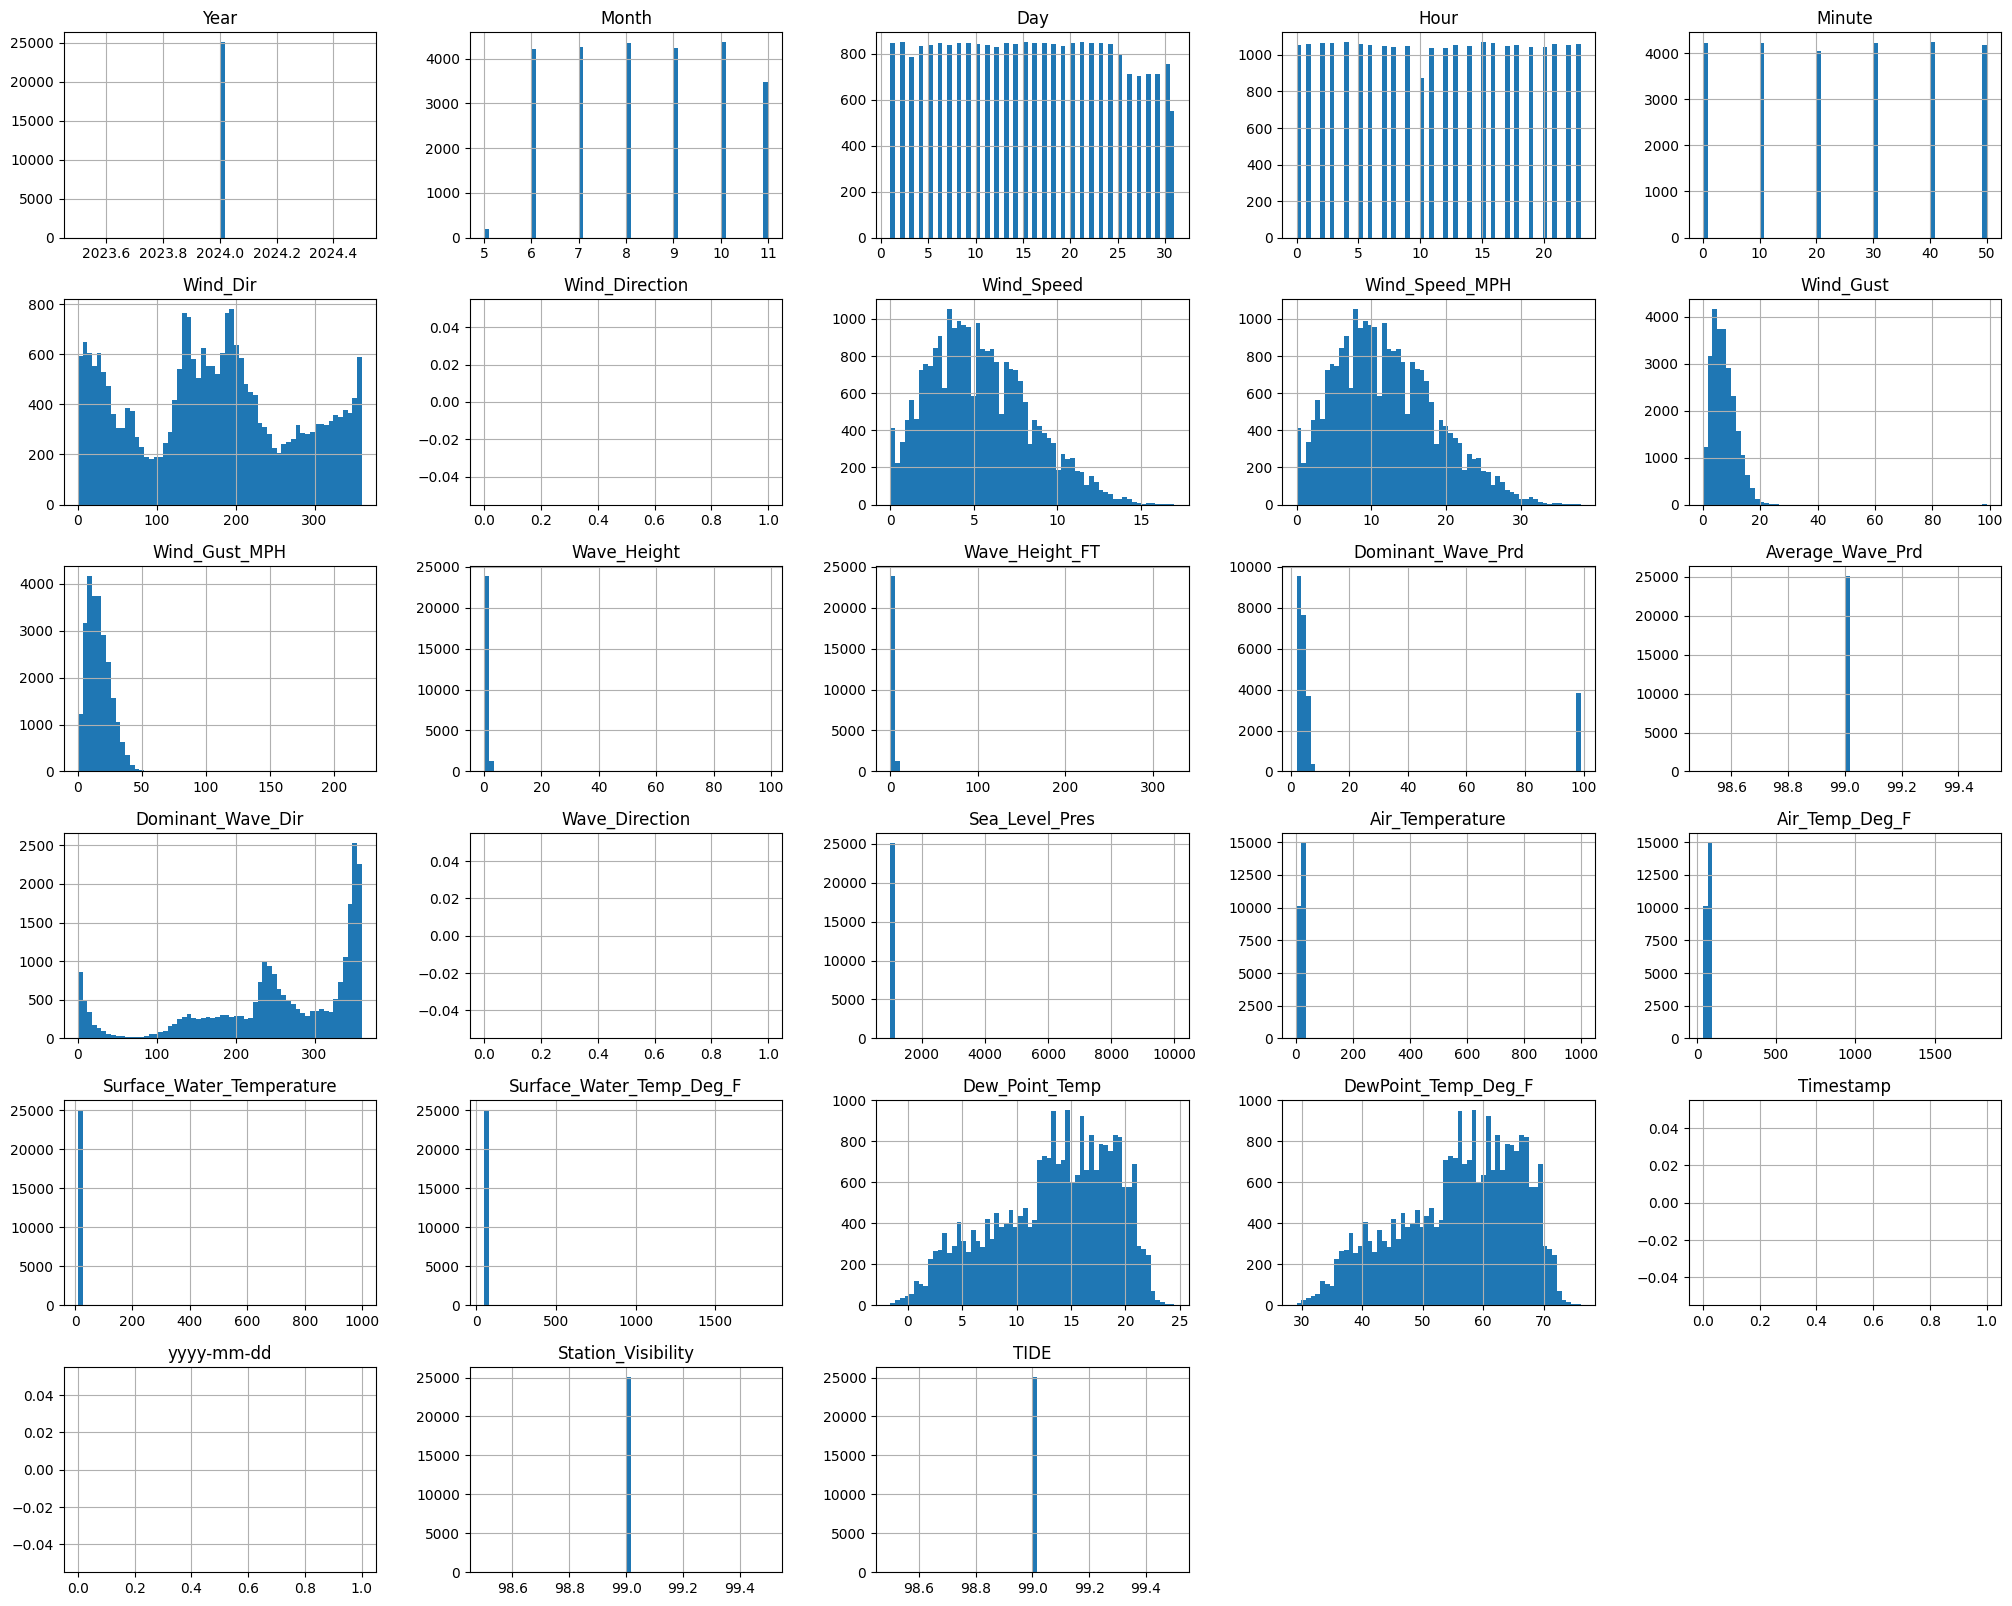

In [186]:
# Run as of 2025-07-27
df2.hist(bins=60,figsize=(25,20))

#### Histogram Analysis

Wind Direction: 

x-axis represents direction in degrees, 0 = N (true North), 90 = E, 180 = S, 270 = W, and 360 = N;
y-axis represents frequency of the bucket values.  For example, between 0 and 100 degrees (so between North and slightly South East wind directions) the distribution is positively skewed with the majority of recordings in this bucket being closer to the North wind direction (lower values); 
Given that wind direction changes through out the day, this histogram of wind direction tells me that the mean wind direction is likely between 150 degrees to 200 degrees (South East to SSW) indicating from the buoy's vantage point, wind coming from the North, North West region.

Wind Speed:

Positively skewed with the majority of recordings indicating wind speed at around 10 mph


Wind Gust:

Positively skewed indicating majority of records show wind gust less than 50 mph


Dominant Wind Direction:

Is an indication of the direction the wave's force is traveling from.  This histogram shows that the dominant wind direction is negatively skewed in relation to its direction, indicating the majority wave energy is coming from the north


Dew Point:

Is negatively skewed with the mean appearing to be around 60 degrees Farenheit